# 한영 번역기 만들기 Project

## 0. 라이브러리 버전 확인

In [1]:
import pandas
import tensorflow
import matplotlib
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import time
import re
import os
import io

print(tf.__version__)
print(pandas.__version__)
print(tensorflow.__version__)
print(matplotlib.__version__)

2.6.0
1.3.3
2.6.0
3.4.3


## 1. 데이터 가져오기

In [6]:
import os

# 파일 경로 설정
path_to_file = os.path.join('aiffel/korean-english', 'korean-english-park.train.ko')

# 파일을 열고 데이터를 읽기
with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))
print("Example:")

for sen in raw[0:100][::20]: print(">>", sen)


Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [5]:
# 파일 경로 설정
path_to_file = os.path.join('aiffel/korean-english', 'korean-english-park.train.en')

# 파일을 열고 데이터를 읽기
with open(path_to_file, "r") as f:
    raw = f.read().splitlines()
print("Data Size:", len(raw))
print("Example:")

for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.


# 2. 데이터 정제

### 2-1) 중복된 데이터 제거

In [9]:
import os

# 한국어와 영어 파일 경로 설정
path_to_korean_file = os.path.join('aiffel/korean-english', 'korean-english-park.train.ko')
path_to_english_file = os.path.join('aiffel/korean-english', 'korean-english-park.train.en')

# 한국어와 영어 문장을 병렬로 담을 리스트
parallel_sentences = []

# 두 파일을 동시에 읽어서 병렬 리스트로 결합
with open(path_to_korean_file, 'r', encoding='utf-8') as kor_file, \
     open(path_to_english_file, 'r', encoding='utf-8') as eng_file:
    
    for kor_sentence, eng_sentence in zip(kor_file, eng_file):
        # 각 문장을 strip()으로 앞뒤 공백 제거 후 병렬 리스트에 추가
        parallel_sentences.append((kor_sentence.strip(), eng_sentence.strip()))

# 병렬 리스트에서 중복을 제거하여 cleaned_corpus에 저장
cleaned_corpus = list(set(parallel_sentences))

# 중복 제거된 데이터의 총 문장 쌍 개수 출력
print(f"중복 제거 후 병렬 데이터의 총 문장 쌍 개수: {len(cleaned_corpus)}")

# 예시로 중복 제거된 병렬 데이터의 3개 문장 쌍 출력
for i in range(min(3, len(cleaned_corpus))):  # 3개 또는 데이터의 크기만큼 출력
    print(f"문장{i+1}:")
    print(f"  한국어: {cleaned_corpus[i][0]}")
    print(f"  영어: {cleaned_corpus[i][1]}")


중복 제거 후 병렬 데이터의 총 문장 쌍 개수: 78941
문장1:
  한국어: 개방형 서비스 구조를 기반으로 현재 인터넷은 웹 2.0을 기반으로 하는 무료 정보가 많다.
  영어: In the Web 2.0 world of ubiquitous, seamless, horizontal communication, information wants to be free.
문장2:
  한국어: 부시 대통령과 로라 부시 여사는 그를 유머, 지성, 우아함, 친절함으로 세상 사람들을 격려하는 '신뢰받는 대단한 여성'이라고 불렀다.
  영어: President Bush and first lady Laura Bush called her a "remarkable woman of faith" who "inspired people around the world with her humor, intelligence, elegance, and kindness.
문장3:
  한국어: 베네수엘라의 한 지식인은 “커뮤니케이션의 수단을 차단하는 것은 극악 무도한 행위”라며 정부를 비판했다.
  영어: "To close a means of communication is an inexcusable monstrosity.


### 2-2) 한글용 전처리 함수 만들기, 토크나이저: Mecab 사용, start, end 토큰 붙이기

In [16]:
import re
from konlpy.tag import Mecab

# KoNLPy의 mecab 객체 생성
mecab = Mecab()

def preprocess_sentence(sentence, s_token=False, e_token=False, lang='en'):
    sentence = sentence.lower().strip()

    if lang == 'en':
        # 영어 문장 처리
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)  # 문장 부호 앞뒤에 공백 추가
        sentence = re.sub(r'[" "]+', " ", sentence)  # 다중 공백을 단일 공백으로 변경
        sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)  # 알파벳과 문장 부호를 제외한 문자를 제거

        sentence = sentence.strip()

        if s_token:
            sentence = '<start> ' + sentence
        if e_token:
            sentence += ' <end>'

        # 영어 문장은 split()을 사용하여 토큰화
        return sentence.split()

    elif lang == 'ko':
        # 한글 문장 처리
        sentence = re.sub(r"[^가-힣?.!,]+", " ", sentence)  # 한글, 문장 부호 외의 문자 제거
        sentence = sentence.strip()

        # 한글 문장은 KoNLPy의 mecab을 사용하여 토큰화
        tokens = mecab.morphs(sentence)

        if s_token:
            tokens = ['<start>'] + tokens
        if e_token:
            tokens.append('<end>')

        return tokens

# 실제 데이터에서 5개의 예시를 가져와 처리하는 코드
for i in range(5):
    korean_sentence = cleaned_corpus[i][0]
    english_sentence = cleaned_corpus[i][1]
    
    print(f"문장{i+1}:")
    print(preprocess_sentence(english_sentence, s_token=True, e_token=True, lang='en'))
    print(preprocess_sentence(korean_sentence, s_token=True, e_token=True, lang='ko'))
    print()  # 줄 바꿈


문장1:
['<start>', 'in', 'the', 'web', '.', 'world', 'of', 'ubiquitous', ',', 'seamless', ',', 'horizontal', 'communication', ',', 'information', 'wants', 'to', 'be', 'free', '.', '<end>']
['<start>', '개방', '형', '서비스', '구조', '를', '기반', '으로', '현재', '인터넷', '은', '웹', '.', '을', '기반', '으로', '하', '는', '무료', '정보', '가', '많', '다', '.', '<end>']

문장2:
['<start>', 'president', 'bush', 'and', 'first', 'lady', 'laura', 'bush', 'called', 'her', 'a', 'remarkable', 'woman', 'of', 'faith', 'who', 'inspired', 'people', 'around', 'the', 'world', 'with', 'her', 'humor', ',', 'intelligence', ',', 'elegance', ',', 'and', 'kindness', '.', '<end>']
['<start>', '부시', '대통령', '과', '로라', '부시', '여사', '는', '그', '를', '유머', ',', '지성', ',', '우아', '함', ',', '친절', '함', '으로', '세상', '사람', '들', '을', '격려', '하', '는', '신뢰', '받', '는', '대단', '한', '여성', '이', '라고', '불렀', '다', '.', '<end>']

문장3:
['<start>', 'to', 'close', 'a', 'means', 'of', 'communication', 'is', 'an', 'inexcusable', 'monstrosity', '.', '<end>']
['<start>', '베네수엘라

### 2-3) 토큰 길이 40 이하만 남겨두기

In [17]:
# 영어와 한국어 문장의 길이가 40 이하인 데이터만 선별하여 eng_corpus와 kor_corpus에 저장
eng_corpus = []
kor_corpus = []

# 조건을 만족하는 문장 개수 카운트
count = 0

# cleaned_corpus의 모든 문장을 검사하여 조건에 맞는 문장만 선별
for kor_sentence, eng_sentence in cleaned_corpus:
    # 각각의 문장을 전처리하여 토큰화
    eng_tokens = preprocess_sentence(eng_sentence, s_token=True, e_token=True, lang='en')
    kor_tokens = preprocess_sentence(kor_sentence, s_token=True, e_token=True, lang='ko')
    
    # 토큰 길이가 40 이하인 경우만 저장
    if len(eng_tokens) <= 40 and len(kor_tokens) <= 40:
        eng_corpus.append(eng_tokens)
        kor_corpus.append(kor_tokens)
        count += 1  # 조건을 만족하는 문장 개수 증가

# 결과 출력
print(f"토큰의 길이가 40 이하인 문장 수: {count}")
print(f"조건을 만족하는 영어 문장 수: {len(eng_corpus)}")
print(f"조건을 만족하는 한국어 문장 수: {len(kor_corpus)}")

# 예시 출력
print("영어 문장 예시:", eng_corpus[0])
print("한국어 문장 예시:", kor_corpus[0])


토큰의 길이가 40 이하인 문장 수: 60799
조건을 만족하는 영어 문장 수: 60799
조건을 만족하는 한국어 문장 수: 60799
영어 문장 예시: ['<start>', 'in', 'the', 'web', '.', 'world', 'of', 'ubiquitous', ',', 'seamless', ',', 'horizontal', 'communication', ',', 'information', 'wants', 'to', 'be', 'free', '.', '<end>']
한국어 문장 예시: ['<start>', '개방', '형', '서비스', '구조', '를', '기반', '으로', '현재', '인터넷', '은', '웹', '.', '을', '기반', '으로', '하', '는', '무료', '정보', '가', '많', '다', '.', '<end>']


## 3. 데이터 토큰화

In [25]:
import tensorflow as tf

def tokenize(corpus):
    # Tokenizer 생성, 단어 필터링 없이 전체 텍스트에 맞춰 단어를 처리
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    # 텍스트를 시퀀스로 변환
    tensor = tokenizer.texts_to_sequences(corpus)

    # 시퀀스 길이를 맞추기 위해 padding 처리
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')

    return tensor, tokenizer

# 영어와 한국어 코퍼스를 각각 텐서로 변환하고, 토크나이저 얻기
dec_tensor, dec_tokenizer = tokenize(eng_corpus)
enc_tensor, enc_tokenizer = tokenize(kor_corpus)

# 결과 출력
print(f"영어 토큰화 후 텐서 shape: {eng_tensor.shape}")
print(f"한국어 토큰화 후 텐서 shape: {kor_tensor.shape}")

# 예시로 첫 번째 텐서 출력
print("영어 문장 예시 텐서:", eng_tensor[0])
print("한국어 문장 예시 텐서:", kor_tensor[0])

# 토크나이저 단어 수 확인 (단어 수는 적어도 10,000 이상)
print(f"영어 단어 집합 크기: {len(eng_tokenizer.word_index) + 1}")  # +1은 패딩을 위한 0 인덱스
print(f"한국어 단어 집합 크기: {len(kor_tokenizer.word_index) + 1}")


영어 토큰화 후 텐서 shape: (60799, 40)
한국어 토큰화 후 텐서 shape: (60799, 40)
영어 문장 예시 텐서: [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     3     9     1   473     2
    84     7 10536     5 18347     5 13152  3010     5   426   647     6
    29   412     2     4]
한국어 문장 예시 텐서: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    1 2450  731  635  441   12 1796   21  141  371    9  543    3
    7 1796   21   13    6 2366  317   15  122    4    3    2]
영어 단어 집합 크기: 37767
한국어 단어 집합 크기: 36339


### 결과를 보고나서의 궁금증.
다른 그루분은 vocab size를 약 1만 오천개로 하였는데 vocab size가 3만 7천개인게 오히려 성능을 감소시킨거였을까?
이전에 vocab size 별로 성능 비교를 했을 때 큰 차이가 안나고, 오히려 1만개 이하로 했을 때는 성능이 감소해서 전체 단어를 사용하였는데
추가적 실험으로 검증이 필요할 것 같다......

## 4. 모델 설계

In [26]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [27]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

In [28]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [35]:
# 코드를 실행하세요.

BATCH_SIZE     = 32
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 512
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (32, 30, 512)
Decoder Output: (32, 37767)
Decoder Hidden State: (32, 512)
Attention: (32, 30, 1)


### 실험할 수 있는 것들
1. dropout 추가하기
2. Embedding Size
3. Hidden Size

오류 발생 사항
GPU 용량 문제로 BATCH SIZE = 64 -> 32로 감소
32 선정 이유: BATCH SIZE는 GPU의 메모리 시스템은 2의 거듭제곱 크기 단위로 데이터를 처리하는 데 최적화되어 있어, 64보다 작은 32로 선정
UNITS : 1024 -> 512로 선정

### (1) Optimizer & Loss

In [36]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

### (2) train_step 구현하기

In [37]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

### (3) 훈련 시작하기

In [38]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_tensor[idx:idx+BATCH_SIZE],
                                dec_tensor[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 10: 100%|██████████| 1900/1900 [06:05<00:00,  5.20it/s, Loss 4.0741]


In [47]:
# Accuracy 계산 함수
def calculate_accuracy(tgt, pred):
    # pred에서 가장 확률이 높은 단어의 인덱스
    pred_ids = tf.argmax(pred, axis=-1)

    # tgt와 pred_ids가 일치하는지 확인하고, 일치하는지 여부를 1과 0으로 반환
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tgt, pred_ids), dtype=tf.float32))
    return accuracy

# 평가 함수
def evaluate_accuracy(encoder, decoder, enc_tensor, dec_tensor, BATCH_SIZE, enc_tokenizer, dec_tokenizer):
    total_accuracy = 0
    num_batches = enc_tensor.shape[0] // BATCH_SIZE

    for batch in range(num_batches):
        # 배치 데이터를 가져오기
        src = enc_tensor[batch * BATCH_SIZE:(batch + 1) * BATCH_SIZE]
        tgt = dec_tensor[batch * BATCH_SIZE:(batch + 1) * BATCH_SIZE]

        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

        batch_accuracy = 0

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)
            batch_accuracy += calculate_accuracy(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)

        total_accuracy += batch_accuracy / int(tgt.shape[1])

    # 배치 단위로 나눠 정확도의 평균을 반환
    return total_accuracy / num_batches

# 훈련이 끝난 후, 정확도 계산
accuracy = evaluate_accuracy(encoder, decoder, enc_tensor, dec_tensor, BATCH_SIZE, enc_tokenizer, dec_tokenizer)
print(f"훈련 후 정확도: {accuracy.numpy():.4f}")


KeyboardInterrupt: 

## 5. 평가하기

번역 1: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


/tmp/ipykernel_125/37258848.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_125/37258848.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


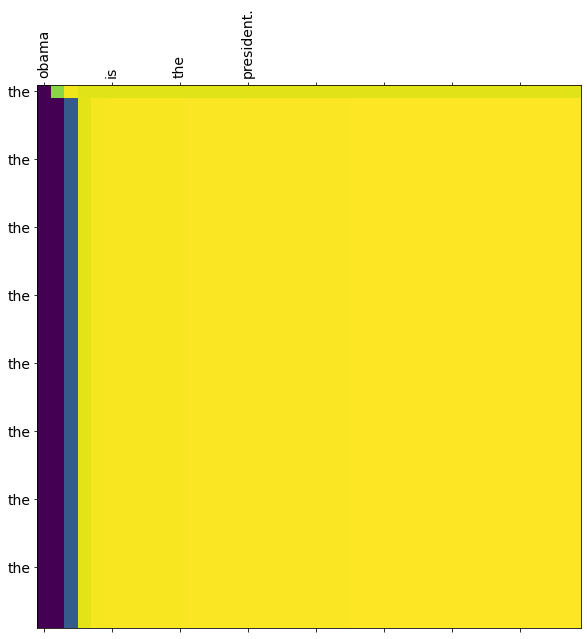

번역 2: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


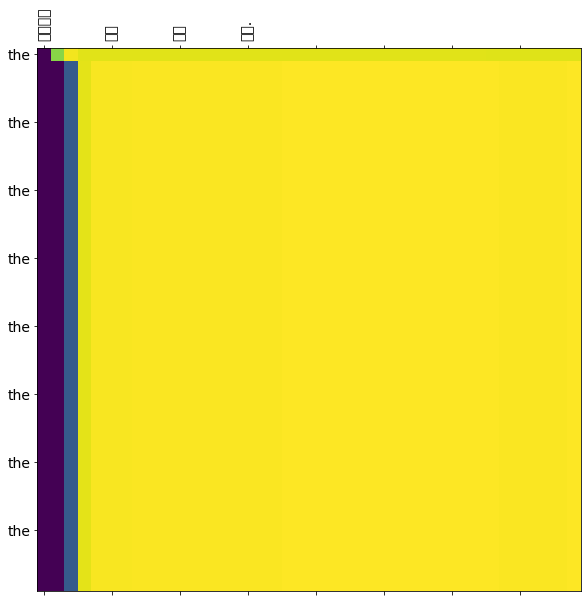

번역 3: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


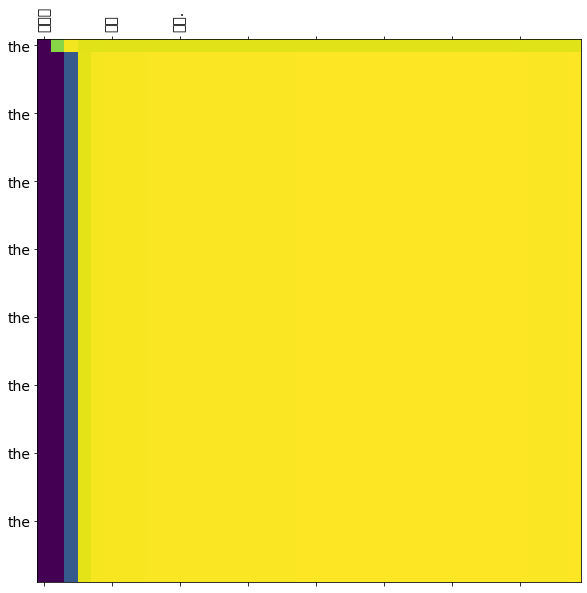

번역 4: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


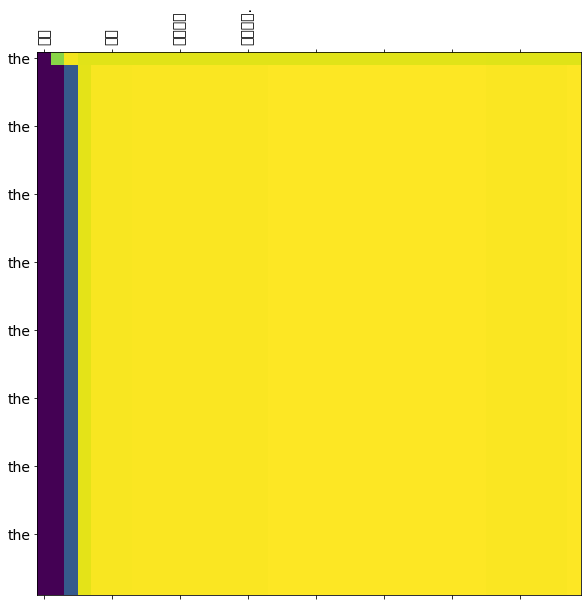

In [48]:
import numpy as np
import matplotlib.pyplot as plt

def evaluate(sentence, encoder, decoder, enc_tokenizer, dec_tokenizer, max_length=40):
    # 입력 문장을 전처리하고 토큰화
    sentence = preprocess_sentence(sentence, s_token=False, e_token=False, lang='ko')
    inputs = [enc_tokenizer.word_index.get(word, 1) for word in sentence]  # 1은 OOV 처리
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length, padding='pre')
    inputs = tf.convert_to_tensor(inputs)

    # 인코더에 입력
    enc_out = encoder(inputs)

    # 디코더의 은닉 상태 초기화
    h_dec = enc_out[:, -1]  # 인코더의 마지막 은닉 상태

    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    result = ''
    attention_plot = np.zeros((max_length, max_length))

    # 디코더에서 문장 생성
    for t in range(max_length):
        predictions, h_dec, attention_weights = decoder(dec_input, h_dec, enc_out)

        attention_weights = tf.reshape(attention_weights, (-1,))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += dec_tokenizer.index_word.get(predicted_id, '') + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            break

        dec_input = tf.expand_dims([predicted_id], 0)

    return result.strip(), attention_plot

def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

# 예문을 번역
korean_sentences = [
    "obama is the president.",
    "시민들은 도시 속에 산다.",
    "커피는 필요 없다.",
    "일곱 명의 사망자가 발생했다."
]

for i, sentence in enumerate(korean_sentences):
    result, attention_plot = evaluate(sentence, encoder, decoder, enc_tokenizer, dec_tokenizer)
    print(f"번역 {i+1}: {result}")
    plot_attention(attention_plot, sentence.split(), result.split())


## 회고
1. 보캡 사이즈를 줄여야 할까?
2. 